# Curiosity-driven exploration with causality prior in VectorIncrement environment

Based on https://pathak22.github.io/noreward-rl/

Setting the right GPU

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm

tf.compat.v1.enable_v2_behavior()

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics, py_metrics
from tf_agents.policies import random_tf_policy, epsilon_greedy_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.networks import actor_distribution_network
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import array_spec
from tf_agents.environments import utils, wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers import py_driver

from vectorincrement import *
from common import *
from curiosity import *

Environment hyperparameters

In [3]:
v_n = 2
v_k = 2
v_seed = 43
do_transform = True
time_limit = 20

Agent hyperparameters

In [4]:
num_iterations = 500 # @param {type:"integer"}
collect_episodes_per_iteration = 5 # @param {type:"integer"}
replay_buffer_capacity = 1000 # @param {type:"integer"}

fc_layer_params = ()

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 10 # @param {type:"integer"}

Decoder: a linear transformation from observations to features

In [5]:
l2_decoder_coeff = 1e-3 # to prevent weight explosion from the l1 loss

In [6]:
# two layers, will sync parameters between them

decoder_layer = tf.keras.layers.Dense(v_n, input_shape=(v_k,), activation=None,
                             use_bias=False, kernel_initializer='random_normal',
                             kernel_regularizer = tf.keras.regularizers.l2(l2_decoder_coeff))

decoder_layer_agent = tf.keras.layers.Dense(v_n, input_shape=(v_k,), activation=None,
                             use_bias=False, kernel_initializer='random_normal',
                             kernel_regularizer = tf.keras.regularizers.l2(l2_decoder_coeff))

decoder = tf.keras.Sequential(
    [
        decoder_layer
    ]
)

Model of the environment

In [7]:
l1coeff = 1e-2

model_train_epochs = 10

In [8]:
env_model = tf.keras.Sequential([
    m_passthrough_action(decoder, v_k, v_n),
    tf.keras.layers.InputLayer(input_shape=(v_k + v_n,)), # input: [state, one-hot action]
    tf.keras.layers.Dense(v_k, kernel_regularizer=tf.keras.regularizers.l1(l1coeff)) # output: state
])

env_model.compile('adam', 'mse')

Curiosity parameters

In [9]:
alpha = 1.0

curiosity_interval = 20

Creating a curiosity-wrapped environment

In [10]:
def get_env(add_curiosity_reward=True):
    """Return a copy of the environment."""
    env = VectorIncrementEnvironmentTFAgents(v_n=v_n, v_k=v_k, v_seed=v_seed,
                                             do_transform=do_transform)
    env = wrappers.TimeLimit(env, time_limit)
    if add_curiosity_reward:
        env = CuriosityWrapper(env, env_model, alpha=alpha)
    env = tf_py_environment.TFPyEnvironment(env)
    return env

In [11]:
train_env = get_env(add_curiosity_reward=True)
eval_env = get_env(add_curiosity_reward=False)

In [12]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params,
    activation_fn=tf.keras.activations.relu,
    preprocessing_layers=decoder_layer_agent
    # for features: add preprocessing_layers=[...]
)

In [13]:
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

In [14]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

In [15]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [16]:
curiosity_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=1000000) # should never overflow

In [17]:
decoder_layer_agent = actor_net.layers[0].layers[0] # taking the copied layer with actual weights

Agent train step
DECODER:[[-0.0697959  -0.00308524]
 [-0.00708889  0.04244918]]
MODEL:[array([[ 0.25339055,  0.9880707 ],
       [ 0.03676939,  0.5841136 ],
       [ 0.05980778, -0.7604344 ],
       [-0.9825578 , -0.6252358 ]], dtype=float32), array([0., 0.], dtype=float32)]
Agent train step
DECODER:[[-0.06977716 -0.00313098]
 [-0.00706076  0.0423805 ]]
MODEL:[array([[ 0.25339055,  0.9880707 ],
       [ 0.03676939,  0.5841136 ],
       [ 0.05980778, -0.7604344 ],
       [-0.9825578 , -0.6252358 ]], dtype=float32), array([0., 0.], dtype=float32)]
Agent train step
DECODER:[[-0.06972814 -0.00325062]
 [-0.00688241  0.04194515]]
MODEL:[array([[ 0.25339055,  0.9880707 ],
       [ 0.03676939,  0.5841136 ],
       [ 0.05980778, -0.7604344 ],
       [-0.9825578 , -0.6252358 ]], dtype=float32), array([0., 0.], dtype=float32)]
Agent train step
DECODER:[[-0.06972394 -0.00326089]
 [-0.00687853  0.04193568]]
MODEL:[array([[ 0.25339055,  0.9880707 ],
       [ 0.03676939,  0.5841136 ],
       [ 0.0598

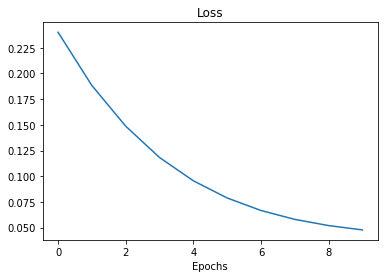

Model train step
DECODER:[[0.2616532  0.3481533 ]
 [0.4304377  0.49231288]]
MODEL:[array([[ 0.00702249,  0.8601975 ],
       [ 0.02774482,  0.6687271 ],
       [-0.3886295 , -0.41740286],
       [-0.58533955, -0.35065615]], dtype=float32), array([0.28682694, 0.25298247], dtype=float32)]
Agent train step
DECODER:[[0.2616339  0.34820047]
 [0.43038574 0.49243984]]
MODEL:[array([[ 0.00702249,  0.8601975 ],
       [ 0.02774482,  0.6687271 ],
       [-0.3886295 , -0.41740286],
       [-0.58533955, -0.35065615]], dtype=float32), array([0.28682694, 0.25298247], dtype=float32)]
Agent train step
DECODER:[[0.26157278 0.34835026]
 [0.43028224 0.49269342]]
MODEL:[array([[ 0.00702249,  0.8601975 ],
       [ 0.02774482,  0.6687271 ],
       [-0.3886295 , -0.41740286],
       [-0.58533955, -0.35065615]], dtype=float32), array([0.28682694, 0.25298247], dtype=float32)]
Agent train step
DECODER:[[0.26162633 0.34821805]
 [0.43057117 0.49198022]]
MODEL:[array([[ 0.00702249,  0.8601975 ],
       [ 0.0277448

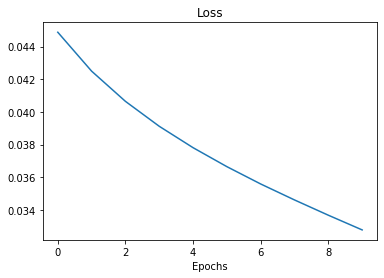

Model train step
DECODER:[[0.2945217  0.4739922 ]
 [0.63726455 0.76593053]]
MODEL:[array([[ 0.0223561 ,  0.59410274],
       [ 0.1849441 ,  0.5598321 ],
       [-0.40909985, -0.2536603 ],
       [-0.46281332, -0.1917012 ]], dtype=float32), array([0.33364636, 0.15779427], dtype=float32)]
Agent train step
DECODER:[[0.29450354 0.4740356 ]
 [0.637211   0.7660585 ]]
MODEL:[array([[ 0.0223561 ,  0.59410274],
       [ 0.1849441 ,  0.5598321 ],
       [-0.40909985, -0.2536603 ],
       [-0.46281332, -0.1917012 ]], dtype=float32), array([0.33364636, 0.15779427], dtype=float32)]
Agent train step
DECODER:[[0.294554   0.47391444]
 [0.63734424 0.7657386 ]]
MODEL:[array([[ 0.0223561 ,  0.59410274],
       [ 0.1849441 ,  0.5598321 ],
       [-0.40909985, -0.2536603 ],
       [-0.46281332, -0.1917012 ]], dtype=float32), array([0.33364636, 0.15779427], dtype=float32)]
Agent train step
DECODER:[[0.294529   0.47397378]
 [0.63724786 0.7659672 ]]
MODEL:[array([[ 0.0223561 ,  0.59410274],
       [ 0.1849441

In [ ]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
train_avg_return = compute_avg_return(eval_env, tf_agent.collect_policy, num_eval_episodes)
returns = [avg_return]
train_returns = [train_avg_return]
curiosity_loss = []

def print_weights():
    """Show weights."""
    print("DECODER:" + str(decoder_layer_agent.get_weights()[0]))
    print("MODEL:" + str(env_model.layers[2].get_weights()))

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(train_env, tf_agent.collect_policy,
                  collect_episodes_per_iteration,
                  [replay_buffer,curiosity_replay_buffer])

  # Use data from the buffer and update the agent's network.
  experience = replay_buffer.gather_all()
  train_loss = tf_agent.train(experience)
  replay_buffer.clear()
    
  print("Agent train step")
  print_weights()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    train_avg_return = compute_avg_return(train_env, tf_agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1} Train curiosity Average return = {2}'.format(step, avg_return,
                                                                      train_avg_return))
    returns.append(avg_return)
    train_returns.append(train_avg_return)
    
  if step % curiosity_interval == 0:
    xs, ys = buffer_to_dataset(curiosity_replay_buffer, v_n)
    
    # setting weights from the agent to the model...
    decoder_layer.set_weights(decoder_layer_agent.get_weights())
    history = env_model.fit(xs, ys, epochs=model_train_epochs, verbose=0)
    
    # setting weights from the model to the agent...
    decoder_layer_agent.set_weights(decoder_layer.get_weights())
    
    plt.title("Loss")
    plt.plot(history.history['loss'])
    curiosity_loss += list(history.history['loss'])
    plt.xlabel("Epochs")
    plt.show()
    curiosity_replay_buffer.clear()
    
    print("Model train step")
    print_weights()

In [ ]:
plt.title("Curiosity loss")
plt.plot(curiosity_loss)
plt.show()

In [ ]:
steps = range(0, num_iterations + 1, eval_interval)
fig = plt.figure()
fig.patch.set_facecolor('lightgreen')
plt.title("Returns with added curiosity reward in training")
plt.plot(steps, returns, label="eval")
plt.plot(steps, train_returns, label="train")
plt.ylabel('Average Return')
plt.legend()
plt.xlabel('Step')

Evaluating the model

In [ ]:
curiosity_replay_buffer.clear()
collect_episode(eval_env, tf_agent.collect_policy, 25, [curiosity_replay_buffer])
collect_episode(eval_env, tf_agent.policy, 25, [curiosity_replay_buffer])
xs, ys = buffer_to_dataset(curiosity_replay_buffer, v_n)
env_model.evaluate(xs, ys)